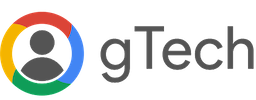

# **Bidding IQ**

In [ ]:
###########################################################################
#
#  Copyright 2021 Google Inc.
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      https://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
# This solution, including any related sample code or data, is made available
# on an “as is,” “as available,” and “with all faults” basis, solely for
# illustrative purposes, and without warranty or representation of any kind.
# This solution is experimental, unsupported and provided solely for your
# convenience. Your use of it is subject to your agreements with Google, as
# applicable, and may constitute a beta feature as defined under those
# agreements.  To the extent that you make any data available to Google in
# connection with your use of the solution, you represent and warrant that you
# have all necessary and appropriate rights, consents and permissions to permit
# Google to use and process that data.  By using any portion of this solution,
# you acknowledge, assume and accept all risks, known and unknown, associated
# with its usage, including with respect to your deployment of any portion of
# this solution in your systems, or usage in connection with your business,
# if at all.
###########################################################################

# **1) Imports & Functions**

*No user action required*

In [ ]:
# @title 1.1) Installs {"display-mode":"form"}
%%capture
try:
  first_run
except NameError:
  first_run = True

if first_run:
  from google.oauth2.service_account import Credentials
  from google.colab import auth, output, files
  output.clear()
  auth.authenticate_user()
  from google.colab import drive
  drive.mount('/content/drive', force_remount=False)
  !pip install ydf
  !pip install --no-deps gps_building_blocks
  !pip install --upgrade pandas
  first_run = False

In [ ]:
# @title 1.2) Imports {"display-mode":"form"}
%%capture

from google.cloud import bigquery
from google.auth import default
import os
from textwrap import wrap
from datetime import datetime
from zoneinfo import ZoneInfo
import gspread
import json
import ipywidgets as widgets
from IPython.display import display, HTML
import pandas as pd
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold
import statsmodels.api as sm
import ydf
from gps_building_blocks.ml.statistical_inference import data_preparation
from gps_building_blocks.ml.statistical_inference import models

In [ ]:
# @title 1.3) Functions {"display-mode":"form"}


def get_best_lag(df, max_lag=15):
  best_lag = 0
  best_corr = 0
  if len(df['impressions']) > 1 and len(df['target_variable']) > 1:
    for lag in range(max_lag):
      impressions = df['impressions'].astype(float)
      target_variable = df['target_variable'].shift(lag).astype(float)
      corr = impressions.corr(target_variable)
      if corr > best_corr:
        best_corr = corr
        best_lag = lag
  return best_lag


def plot_lower_triangle_corr(df):
  # Compute the correlation matrix
  corr = df.corr()

  # Generate a mask for the upper triangle
  mask = np.triu(np.ones_like(corr, dtype=bool))

  # Set up the matplotlib figure
  f, ax = plt.subplots(figsize=(11, 11))

  # Generate a custom diverging colormap
  cmap = sns.diverging_palette(230, 20, as_cmap=True)

  # Draw the heatmap with the mask and correct aspect ratio
  sns.heatmap(
      corr,
      mask=mask,
      cmap=cmap,
      vmax=1,
      center=0,
      square=True,
      linewidths=0.5,
      cbar_kws={'shrink': 0.5},
  )
  plt.show()


def combine_dataframes_by_date(dataframes):
  """Combines multiple Pandas DataFrames with a common 'date' column into a single master DataFrame,

  then calculates Audible Impressions

  Args:
      dataframes: A list of Pandas DataFrames to combine.

  Returns:
      A master Pandas DataFrame with a single 'date' column (dbdate format), all
      unique columns from the input DataFrames, a new audible impressions column
      where applicable,
      and NaN values replaced with 0.
  """

  merged_df = dataframes[0]

  for df in dataframes[1:]:
    merged_df = pd.merge(merged_df, df, on='date', how='outer')

  # Convert 'date' to datetime and then to dbdate format
  merged_df['date'] = pd.to_datetime(merged_df['date'], format='mixed')

  # Replace NaN values with 0
  merged_df.fillna(0, inplace=True)

  # Check if 'active_view_percent_audible_impressions' exists
  if 'active_view_percent_audible_impressions' in merged_df.columns:
    # Calculate 'audible_impressions' (no need to handle division by zero since NaN values are already 0)
    merged_df['audible_impressions'] = (
        merged_df['active_view_percent_audible_impressions']
        / 100
        * merged_df['active_view_measurable_impressions']
    )
    merged_df = merged_df.drop(
        columns=['active_view_percent_audible_impressions']
    )

  # merged_df = merged_df.columns.str.replace('.','_')

  return merged_df

In [ ]:
# @title 1.4) Drive Setup {"display-mode":"form"}
folder_path = "/content/drive/My Drive/Bidding_IQ"
variable_folder = "/content/drive/My Drive/Bidding_IQ/Saved_Variables"
script_folder = "/content/drive/My Drive/Bidding_IQ/Generated_Scripts"
if not os.path.exists(folder_path):
  os.makedirs(folder_path)
if not os.path.exists(variable_folder):
  os.makedirs(variable_folder)
if not os.path.exists(script_folder):
  os.makedirs(script_folder)


file_path = (
    variable_folder + "/BiddingIQ_Variable_Sets.json"
)  # Specify the file path


def save_variable_set(set_name):
  """Saves the current variable values to a JSON file."""

  # Try to load existing variable sets (if the file exists)
  try:
    # Load existing sets from Google Drive
    with open(file_path, "r") as f:
      all_sets = json.load(f)
  except FileNotFoundError:
    all_sets = {}  # Start with an empty dictionary if the file doesn't exist

  variables = {
      "_CLIENT_NAME": _CLIENT_NAME,
      "_DV3_DATA_SOURCE": _DV3_DATA_SOURCE,
      "_DV3_DIMENSION_DATA_LOCATION": _DV3_DIMENSION_DATA_LOCATION,
      "_DV3_METRIC_DATA_LOCATION": _DV3_METRIC_DATA_LOCATION,
      "_DV3_BQ_PROJECT": _DV3_BQ_PROJECT,
      "_DV3_DIMENSION_WORKSHEET": _DV3_DIMENSION_WORKSHEET,
      "_DV3_METRIC_WORKSHEET": _DV3_METRIC_WORKSHEET,
      "_TARGET_VARIABLE_SOURCE": _TARGET_VARIABLE_SOURCE,
      "_TARGET_VARIABLE_LOCATION": _TARGET_VARIABLE_LOCATION,
      "_DATE_COLUMN_TITLE": _DATE_COLUMN_TITLE,
      "_TARGET_VARIABLE_COLUMN_TITLE": _TARGET_VARIABLE_COLUMN_TITLE,
      "_TARGET_VARIABLE_BQ_PROJECT": _TARGET_VARIABLE_BQ_PROJECT,
      "_TARGET_VARIABLE_WORKSHEET": _TARGET_VARIABLE_WORKSHEET,
  }

  all_sets[set_name] = variables  # Add the new set to the dictionary

  with open(file_path, "w") as f:
    json.dump(all_sets, f)
  print(f"Variable set '{set_name}' saved successfully to Google Drive!")
  return variables


def load_variable_set(set_name):
  """Loads variable values from the JSON file."""

  try:
    with open(file_path, "r") as f:
      all_sets = json.load(f)

    if set_name in all_sets:
      variables = all_sets[set_name]
      globals().update(variables)  # Update global variables
      print(f"Variable set '{set_name}' loaded successfully!")
      for key, value in variables.items():
        print(f"{key}: {value}")
      return variables
    else:
      print(f"Variable set '{set_name}' not found.")
  except FileNotFoundError:
    print("No variable sets have been saved yet.")


def get_saved_set_names():
  """Retrieves and prints a list of all saved variable set names."""
  try:
    with open(file_path, "r") as f:
      all_sets = json.load(f)
    return ["None"] + list(all_sets.keys())  # Add "None" as the first option
  except FileNotFoundError:
    return ["None"]  # Default to "None" if no file exists

# **2) User Inputs**

This is where you will add your data inputs before running the notebook. After
that, the notebook should run entirely on its own.

## 2.1) Model Inputs

*   **Default Media Type** = Display
*   **Default Model** = Default (*See
    [Implementation Guide](https://docs.google.com/document/d/1oOLTo1STn9mCXXEKj95JbpflPhI4x0GHH4zrhRK5L4o/edit?tab=t.0#heading=h.vgol1uz8ixf6)
    for more info on model options*)

If you'd like to change one of these inputs after your initial run, choose the
new value from the dropdown and select Runtime > Run Cell and Below ***while the
relevant cell is still selected.***

In [ ]:
# @markdown  ## Channel Selector {"display-mode":"form"}
_MEDIA_TYPE = "Video"  # @param ["Display", "Video"]

In [ ]:
# @markdown  ## Model Selector {"display-mode":"form"}
_MODEL = "Extra_Pivots"  # @param ["Default", "Include_Weekday", "Extra_Pivots"]

## 2.2) Using Existing Variable Set

If this is your first time using the notebook, skip to the next section.

For return users, this section allows you to reuse variable inputs from a
previous run.

In [ ]:
# @title {"display-mode":"form"}
set_names = get_saved_set_names()  # Get initial set names
dropdown = widgets.Dropdown(
    options=set_names,
    # value=set_names[0], # sets default to "None" or first saved set
    description="Choose a Set:",
    disabled=False,
)
display(dropdown)


print(
    "To use a saved variable set, choose your set name here and then select THE"
    " FOLLOWING CELL & select 'Run Cell and Below' from the Runtime menu or hit"
    " CTRL + F10."
)

In [ ]:
# @title Select this cell and choose Run Cell and Below to use Variable Set {"display-mode":"form"}
selected_set_name = dropdown.value
if selected_set_name != "None":
  _VARIABLES = load_variable_set(selected_set_name)

## 2.3) Using New Variable Inputs

Please follow instructions
[here](https://docs.google.com/document/d/1oOLTo1STn9mCXXEKj95JbpflPhI4x0GHH4zrhRK5L4o/edit?tab=t.0)
on how to pull the DV360 reporting correctly.

**Note:** If using Existing Variable Section, you do not need to take any
actions within this block.

In [ ]:
# @ title {"display-mode":"form"}
if selected_set_name == "None":

  _VARIABLE_SET_NAME = ""  # @param  {type:"string"}

  _CLIENT_NAME = ""  # @param  {type:"string"}

  # @markdown ---

  # @markdown  ## DV360 DATA
  _DV3_DATA_SOURCE = "CSV"  # @param ["BQ", "CSV"]

  # TODO: Consider adding files.upload() functionality so users can choose file with button.
  # -- Button shows at bottom of code block, so need to rearrange or split out into own block
  # -- Would also need to add logic so that there is one final "Data Location" param for both dimension & metric data

  _DV3_DIMENSION_DATA_LOCATION = "" #@param {type:"string"}
  # @markdown <ul><li><strong>BQ:&nbsp;</strong>Use table name (including dataset name). Ex: BiddingIQ_Testing.Metric_Data_Test</li><li><strong>CSV:&nbsp;</strong>Upload CSV to Files section on left. Then use three dot menu to Copy Path and paste here.</li></ul>
  _DV3_METRIC_DATA_LOCATION = "" #@param {type:"string"}
  # @markdown <ul><li><strong>BQ:&nbsp;</strong>Use table name (including dataset name). Ex: BiddingIQ_Testing.Metric_Data_Test</li><li><strong>CSV:&nbsp;</strong>Upload CSV to Files section on left. Then use three dot menu to Copy Path and paste here.</li></ul>

  # @markdown #### BQ Only:
  _DV3_BQ_PROJECT = ""  # @param {type:"string"}

  # @markdown ### Sheets Only:
  _DV3_DIMENSION_WORKSHEET = ""  # @param {type:"string"}
  _DV3_METRIC_WORKSHEET = ""  # @param {type:"string"}

  # @markdown ---

  # @markdown ## TARGET VARIABLE DATA
  _TARGET_VARIABLE_SOURCE = "Sheets"  # @param ["Sheets", "BQ"]
  _TARGET_VARIABLE_LOCATION = "" #@param {type:"string"}
  # @markdown <ul><li><strong>BQ:&nbsp;</strong>Use table name (including dataset name). Ex: BiddingIQ_Testing.Metric_Data_Test</li><li><strong>Sheets:</strong> Use URL. Ex: https://docs.google.com/spreadsheets/d/1YO3jCXyR8IC1OIEM06xj-K5TKB-Axz-R_IArdUNmTO8/</li></ul>

  _DATE_COLUMN_TITLE = "Date"  # @param {type:"string"}
  _TARGET_VARIABLE_COLUMN_TITLE = "Total Orders"  # @param {type:"string"}

  # @markdown #### BQ Only:
  _TARGET_VARIABLE_BQ_PROJECT = ""  # @param {type:"string"}

  # @markdown #### Sheets Only:
  _TARGET_VARIABLE_WORKSHEET = "Sheet1"  # @param {type:"string"}

  # @markdown ---
  _VARIABLES = save_variable_set(_VARIABLE_SET_NAME)

  print(f"Variable set '{_VARIABLE_SET_NAME}' saved successfully!")

## 2.4) Model ID Generation

*No user action required*

In [ ]:
# @title
# Generate a unique ID
model_id = datetime.now().strftime("%y%m%d%H%M%S") + str(os.getpid())

print("Model ID:", model_id)

# **3) Load and prepare data**

### 3.1) Get Data From Source Files

In [ ]:
# @title  {"display-mode":"form"}


# Get data from BigQuery (BQ)
def get_data_from_bq(dataset_name, project_name):
  """Fetches data from a BigQuery dataset and returns a Pandas DataFrame."""
  # client = bigquery.Client()
  client = bigquery.Client(project=project_name)
  query = f'SELECT * FROM `{dataset_name}`'
  df = client.query(query).to_dataframe()
  if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')
  return df


# Get data from Google Sheets (Sheets)
def get_data_from_sheets(sheet_url, worksheet_name):
  """Reads data from a specific worksheet within a Google Sheets URL and returns a Pandas DataFrame.

  Args:
      sheet_url (str): The URL of the Google Sheets document.
      worksheet_name (str): The name of the worksheet to read.

  Returns:
      pandas.DataFrame: A DataFrame containing the data from the specified
      worksheet.
  """

  creds, _ = default()
  gc = gspread.authorize(creds)

  sh = gc.open_by_url(sheet_url)
  worksheet = sh.worksheet(worksheet_name)

  data = worksheet.get_all_values()
  df = pd.DataFrame(data[1:], columns=data[0])

  return df


def get_data_from_csv(file_name):
  """Reads data from a CSV file in the 'Raw CSVs' folder and returns a Pandas DataFrame."""
  df = pd.read_csv(file_name, on_bad_lines='skip', low_memory=False)
  blank_index = df.iloc[:, 0].isnull().idxmax()

  # If a blank row was found, keep only the rows before it
  if blank_index is not None:
    df = df.iloc[:blank_index]
  return df


# Clean Up Fields in DataFrame
def df_cleanup(dataframe_name):
  df = dataframe_name.copy()

  col_rename_map = {
      'Date': 'date',
      'Media Type': 'media_type',
      'Line Item ID': 'line_item_id',
      'Active View: Measurable Impressions': (
          'active_view_measurable_impressions'
      ),
      'Active View: Viewable Impressions': 'active_view_viewable_impressions',
      'Active View: % Audible Impressions': (
          'active_view_percent_audible_impressions'
      ),
      'Active View: Impressions Audible and Visible at Completion': (
          'active_view_audible_visible_on_complete_impressions'
      ),
      'Active View: Audio Measurable Impressions': (
          'active_view_audible_measurable_impressions'
      ),
      'Active View: Impressions Visible 10 Seconds': (
          'active_view_viewable_for_time_threshold'
      ),
      'Clicks': 'clicks',
      'Complete Views (Video)': 'rich_media_video_completions',
      'Impressions': 'impressions',
      'Device Type': 'device_type',
      'Ad Position': 'ad_position',
      'Day of Week': 'day_of_week',
      'Creative Height': 'creative_height',
      'Creative Width': 'creative_width',
      'Video content duration bucket': 'video_content_duration',
      'Video content live stream': 'video_content_live_stream',
      'Video Player Size': 'video_player_size',
  }

  # Rename columns based on mapping
  if col_rename_map:
    df.rename(
        columns=col_rename_map, inplace=True, errors='ignore'
    )  # Rename inplace for efficiency

  # Replace all -- values with 0
  df.replace('--', 0, inplace=True)

  # Replace all Unknown values with null
  df.replace('Unknown', np.nan, inplace=True)

  # Drop columns with all null values
  df.dropna(axis=1, how='all', inplace=True)

  # Convert columns to numeric or boolean format
  for col in df.columns:
    if col == 'active_view_percent_audible_impressions':
      df['active_view_percent_audible_impressions'] = (
          df['active_view_percent_audible_impressions']
          .replace('', np.nan)  # Replace empty strings with NaN
          .astype(str)
          .str.replace('%', '', regex=False)
          .astype(float)
          / 100
      )

    if df[col].isin([0, 1]).all():
      df[col] = df[col].astype(bool)

    try:
      df[col] = pd.to_numeric(df[col])
      if (
          df[col].dtype == 'float64'
      ):  # Check for float64 before converting to int64
        df[col] = df[col].fillna(0).astype('int64')
        if (df[col] % 1 == 0).all():  # Check if all values are whole numbers
          df[col] = df[col].astype('Int64')
    except ValueError:
      pass  # Column cannot be converted to numeric, leave it as is
  if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')

  return df


# Load DataFrames based on user configuration
if _DV3_DATA_SOURCE == 'BQ':
  df_dv3_dimension = get_data_from_bq(
      _DV3_DIMENSION_DATA_LOCATION, _DV3_BQ_PROJECT
  )
  df_dv3_metric = get_data_from_bq(_DV3_METRIC_DATA_LOCATION, _DV3_BQ_PROJECT)
elif _DV3_DATA_SOURCE == 'Sheets':
  df_dv3_dimension = df_cleanup(
      get_data_from_sheets(
          _DV3_DIMENSION_DATA_LOCATION, _DV3_DIMENSION_WORKSHEET
      )
  )
  df_dv3_metric = df_cleanup(
      get_data_from_sheets(_DV3_METRIC_DATA_LOCATION, _DV3_METRIC_WORKSHEET)
  )
elif _DV3_DATA_SOURCE == 'CSV':
  df_dv3_dimension = df_cleanup(get_data_from_csv(_DV3_DIMENSION_DATA_LOCATION))
  df_dv3_metric = df_cleanup(get_data_from_csv(_DV3_METRIC_DATA_LOCATION))
else:
  raise ValueError("Invalid DV3 data source. Choose 'BQ' or 'CSV'.")

if _TARGET_VARIABLE_SOURCE == 'BQ':
  df_target_variable = get_data_from_bq(
      _TARGET_VARIABLE_LOCATION, _TARGET_VARIABLE_BQ_PROJECT
  )
elif _TARGET_VARIABLE_SOURCE == 'Sheets':
  df_target_variable = get_data_from_sheets(
      _TARGET_VARIABLE_LOCATION, _TARGET_VARIABLE_WORKSHEET
  )
else:
  raise ValueError("Invalid target variable source. Choose 'BQ' or 'Sheets'.")

# Limit to Correct Columns & Standardize Target Variable Column Names
df_target_variable = df_target_variable[
    [_DATE_COLUMN_TITLE, _TARGET_VARIABLE_COLUMN_TITLE]
]
df_target_variable.rename(
    columns={
        _TARGET_VARIABLE_COLUMN_TITLE: 'target_variable',
        _DATE_COLUMN_TITLE: 'date',
    },
    inplace=True,
)
df_target_variable['date'] = pd.to_datetime(
    df_target_variable['date']
).dt.strftime('%Y-%m-%d')
# df_target_variable['date'] = pd.to_datetime(df_target_variable['date'])


# TODO - Add error handling for dates that are not able to be converted to the correct format (i.e. 01.22.2024) and add documentation that date should be in YYYY-MM-DD format
print('DataFrames loaded successfully:')
print(df_dv3_dimension.head())
print(df_dv3_dimension.columns)
print(df_dv3_metric.head())
print(df_dv3_metric.columns)
print(df_target_variable.head())
print(df_target_variable.columns)

### 3.2) Filter Data Frames by Media Type

In [ ]:
# @title {"display-mode":"form"}
# Define display and video only columns
if _MEDIA_TYPE == 'Video':
  columns_to_drop = ['creative_height', 'creative_width']
if _MEDIA_TYPE == 'Display':
  columns_to_drop = [
      'active_view_percent_audible_impressions',
      'active_view_audible_visible_on_complete_impressions',
      'active_view_audible_measurable_impressions',
      'rich_media_video_completions',
      'audible_impressions',
      'video_content_duration',
      'video_content_live_stream',
      'video_player_size',
  ]


# Filter for Media Type data from both DataFrames
df_dv3_dimension_filtered = df_dv3_dimension[
    df_dv3_dimension['media_type'] == str(_MEDIA_TYPE)
].copy()
df_dv3_metric_filtered = df_dv3_metric[
    df_dv3_metric['media_type'] == _MEDIA_TYPE
].copy()

# Drop unnecessary columns from DataFrames
df_dv3_dimension_filtered = df_dv3_dimension_filtered.drop(
    columns=columns_to_drop + ['media_type'], errors='ignore'
)
df_dv3_metric_filtered = df_dv3_metric_filtered.drop(
    columns=columns_to_drop + ['media_type'], errors='ignore'
)


# Check if dataframes are empty
if df_dv3_dimension_filtered.empty or df_dv3_metric_filtered.empty:
  raise ValueError(
      'One or both of the filtered DV360 dataframes are empty. Please check'
      ' your data and ensure the Media Type of the data aligns with the type'
      ' you chose in Step 2.1'
  )


print('DataFrames successfully refactored.')
print(df_dv3_dimension_filtered.head())
print(df_dv3_metric_filtered.head())

### 3.3) Extract Line Item Data

In [ ]:
# @title {"display-mode":"form"}
def create_line_item_df(combined_df, media_type):
  """Transforms metric data for a specific media type, incorporating day-of-week counts.

  Args:
      df_metric: Dataframe containing metrics for the specific media type (e.g.,
        Display, Video).

  Returns:
      Transformed dataframe with date as the index.
  """
  combined_df = combined_df.copy()
  combined_df['line_item_id'] = combined_df['line_item_id'].astype(str)

  line_item_counts = (
      combined_df.groupby('date')['line_item_id']
      .value_counts()
      .reset_index()
      .pivot(columns=['line_item_id'], values='count', index='date')
      .fillna(0)
  )

  line_item_counts.reset_index(inplace=True)
  line_item_counts.columns.name = None

  if _MODEL != 'Include_Weekday':
    weekday_counts = (
        combined_df.groupby('date')['day_of_week']
        .value_counts()
        .reset_index()
        .pivot(columns='day_of_week', values='count', index='date')
        .fillna(0)
    )
    weekday_counts.reset_index(inplace=True)
    weekday_counts.columns.name = None

    # Join weekday counts and other data
    line_item_df = weekday_counts.join(
        line_item_counts.set_index('date'), on='date'
    )
  else:
    # Initialize an empty df so that final formatting does not error out
    # during include_weekday model type
    line_item_df = pd.DataFrame(line_item_counts)

  # Final formatting
  line_item_df['date'] = pd.to_datetime(line_item_df['date'])
  df_dv3_metric_filtered['date'] = pd.to_datetime(
      df_dv3_metric_filtered['date']
  )
  df_target_variable['date'] = pd.to_datetime(df_target_variable['date'])
  line_item_df = pd.merge(
      line_item_df, df_target_variable[['date', 'target_variable']], on=['date']
  )
  line_item_df = pd.merge(
      line_item_df, df_dv3_metric_filtered[['date', 'impressions']], on=['date']
  )
  line_item_df.set_index('date', inplace=True)
  line_item_df.sort_index(inplace=True)
  line_item_df['impressions'] = pd.to_numeric(
      line_item_df['impressions'], errors='coerce'
  )
  line_item_df['target_variable'] = pd.to_numeric(
      line_item_df['target_variable'], errors='coerce'
  )

  return line_item_df


# day_of_week_df = df_dv3_dimension_filtered.groupby('date')['day_of_week'].value_counts().reset_index()
# dfs_to_merge = [day_of_week_df, df_dv3_metric_filtered]
# merged_df = combine_dataframes_by_date(dfs_to_merge)
# Create separate DataFrames for Line Item Data
line_item_df = create_line_item_df(df_dv3_dimension_filtered, _MEDIA_TYPE)
print(line_item_df.head())

### 3.4) Pivot Dimension DFs

In [ ]:
# @title {"display-mode":"form"}
def pivot_and_format_df(
    df,
    exclude_columns=[
        'date',
        'impressions',
        'clicks',
        'active_view_viewable_impressions',
    ],
    index_col='date',
    value_col='impressions',
):
  """Pivots a DataFrame based on specified columns, formats column names, fills NaN values,

  and drops columns with insignificant sums compared to the original value
  column.

  Args:
      df: The DataFrame to pivot.
      exclude_columns: A list of columns to exclude from pivoting (default is
        ['date', 'impressions']).
      index_col: The column to use as the index (default is 'date').
      value_col: The column to use as the values (default is 'impressions').

  Returns:
      A list of pivoted and formatted DataFrames.
  """

  # Calculate the total sum of the value column at the beginning
  total_value_sum = df[value_col].sum()

  # Get columns to pivot
  columns_to_pivot = [col for col in df.columns if col not in exclude_columns]

  if _MODEL != 'Include_Weekday':
    columns_to_pivot.remove('day_of_week')

  my_list = []
  pivot_dfs = []
  pivot_volumes = {}
  for col in columns_to_pivot:
    temp_df = df[[col, index_col, value_col]]
    pivot_df = temp_df.pivot_table(
        index=index_col, columns=col, values=value_col, aggfunc='sum'
    )
    pivot_df.columns = pivot_df.columns.astype(str)
    pivot_df.columns = [
        f"{col}___{x.replace(' ', '_').replace('.', '_')}"
        for x in pivot_df.columns
    ]
    if value_col != 'impressions':
      pivot_df.columns = [f'{x}__AND__{value_col}' for x in pivot_df.columns]
    pivot_df = pivot_df.fillna(0).reset_index()
    pivot_df['date'] = pd.to_datetime(pivot_df['date']).dt.strftime('%Y-%m-%d')

    # Calculate the sum of each new column and compare to the total value sum
    for column in pivot_df.columns:
      if column != 'date':
        column_sum = pivot_df[column].sum()
        comparison = column_sum / total_value_sum
        pivot_volumes[column] = comparison
        if comparison < 0.0001:  # 0.01% threshold
          pivot_df = pivot_df.drop(column, axis=1)

    my_list = my_list + pivot_df.columns.tolist()
    pivot_dfs.append(pivot_df)
  print(pivot_volumes)
  return pivot_dfs


# Drop Line Item Data from final DataFrames
df_dv3_dimension_grouped = df_dv3_dimension_filtered.drop(
    columns=['line_item_id']
)
# Group by all remaining columns and sum 'impressions'
df_dv3_dimension_grouped = (
    df_dv3_dimension_grouped.groupby(
        df_dv3_dimension_grouped.columns.difference(['impressions']).tolist()
    )
    .agg({'impressions': 'sum'})
    .reset_index()
)

# Pivot and format DataFrames using the function
pivot_dimension_dfs = pivot_and_format_df(df_dv3_dimension_grouped)

if _MODEL == 'Extra_Pivots':
  extra_pivots_df = pivot_and_format_df(
      df_dv3_dimension_grouped, value_col='clicks'
  )
  pivot_dimension_dfs.extend(extra_pivots_df)
  extra_pivots_df = pivot_and_format_df(
      df_dv3_dimension_grouped, value_col='active_view_viewable_impressions'
  )
  pivot_dimension_dfs.extend(extra_pivots_df)

print('DataFrames successfully pivoted.')
for items in pivot_dimension_dfs:
  print(items.columns.tolist())

### 3.5) Concat All Data (incl Metric Data)

In [ ]:
# @title {"display-mode":"form"}

# Add Metric DFs to the list to be combined
pivot_dimension_dfs.append(df_dv3_metric_filtered)

# Add Target Variable DFs to the list to be combined
pivot_dimension_dfs.append(df_target_variable)

# Concatenate pivoted dataframes

for df in pivot_dimension_dfs:
  df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')

final_df = combine_dataframes_by_date(pivot_dimension_dfs)
final_df['target_variable'] = pd.to_numeric(
    final_df['target_variable'], errors='coerce'
)
final_df = final_df[final_df['target_variable'] > 0]
final_df = final_df[final_df['impressions'] > 0]

print('Final DataFrames ready for model usage.')
print(final_df.columns.tolist())

final_df.head()

# **4) Run Model**

### 4.1) Find Best Lag & Shift Data

In [ ]:
# @title {"display-mode":"form"}
best_lag = get_best_lag(final_df)
final_df['target_variable'].shift(best_lag)
final_df.dropna(inplace=True)
print(final_df.head())

### 4.2) Normalise data by number of daily impressions

In [ ]:
# @title {"display-mode":"form"}
line_item_df['impressions'] = pd.to_numeric(
    line_item_df['impressions'], errors='coerce'
)
line_item_df['target_variable'] = pd.to_numeric(
    line_item_df['target_variable'], errors='coerce'
)
line_item_df = line_item_df[line_item_df['target_variable'] > 0]
line_item_df = line_item_df[line_item_df['impressions'] > 0]

line_item_display_df_normalised = line_item_df.divide(
    line_item_df['impressions'], axis=0
)
line_item_display_df_normalised.drop(['impressions'], axis=1, inplace=True)

line_item_display_df_normalised = line_item_display_df_normalised[
    line_item_display_df_normalised['target_variable'] < 1
]

In [ ]:
# @title {"display-mode":"form"}

final_df['target_variable'] = pd.to_numeric(
    final_df['target_variable'], errors='coerce'
)
final_df['impressions'] = pd.to_numeric(
    final_df['impressions'], errors='coerce'
)
print(final_df.head())
final_df.set_index('date', inplace=True)

df_normalised = final_df.divide(final_df['impressions'], axis=0)
df_normalised = df_normalised[df_normalised['target_variable'] < 1]

## 4.3) Debias KPI from Line Item ID

Reference:
https://matheusfacure.github.io/python-causality-handbook/22-Debiased-Orthogonal-Machine-Learning.html

In [ ]:
# @title {"display-mode":"form"}
X = line_item_display_df_normalised
print(X.head())
y_predicted = pd.DataFrame(
    index=X.index, columns=['prediction', 'prediction_train']
)
kf = KFold(n_splits=5, shuffle=True, random_state=1)
for i, (train_index, test_index) in enumerate(kf.split(X)):
  train_ds = X.iloc[train_index]
  test_ds = X.iloc[test_index]
  model = ydf.GradientBoostedTreesLearner(
      label='target_variable', task=ydf.Task.REGRESSION
  ).train(train_ds)
  y_pred = model.predict(test_ds)
  y_pred_train = model.predict(train_ds)
  y_predicted.iloc[test_index, 0] = y_pred
  y_predicted.iloc[train_index, 1] = y_pred_train
y_res = X['target_variable'] - y_predicted['prediction']

## 4.4) Debias each feature from Line Item ID

In [ ]:
# @title
feature_columns = []
other_columns = ['date', 'target_variable', 'impressions']
for col in final_df.columns:
  if col not in other_columns:
    feature_columns.append(col)
print(feature_columns)

In [ ]:
# @title
df_residuals = pd.DataFrame(index=df.index, columns=feature_columns)
X = line_item_display_df_normalised.drop(['target_variable'], axis=1)
for col_idx, col in enumerate(feature_columns):
  y = df_normalised[col]
  ds = X.merge(y, left_index=True, right_index=True)
  y_predicted = pd.DataFrame(index=X.index, columns=['prediction'])
  kf = KFold(n_splits=5, shuffle=True, random_state=1)
  for i, (train_index, test_index) in enumerate(kf.split(ds)):
    train_ds = ds.iloc[train_index]
    test_ds = ds.iloc[test_index]
    model = ydf.GradientBoostedTreesLearner(
        label=col, task=ydf.Task.REGRESSION
    ).train(train_ds)
    y_pred = model.predict(test_ds)
    df_residuals.iloc[test_index, col_idx] = y_pred - test_ds[col]

df_residuals.dropna(inplace=True)
y_res.dropna(inplace=True)

print(y_res.shape)
df_residuals.shape

df_residuals['target'] = y_res.values

## 4.5) Run inference model

In [ ]:
# @title
X_cols = feature_columns
plot_lower_triangle_corr(df_residuals)
TARGET = 'target'
for col in df_residuals.columns:
  df_residuals[col] = df_residuals[col].astype(float)
data_scaled = df_residuals.copy()
for col in data_scaled.columns:
  data_scaled[col] = (data_scaled[col] - data_scaled[col].mean()) / data_scaled[
      col
  ].std()
inference_data = data_preparation.InferenceData(
    initial_data=data_scaled[X_cols + [TARGET]], target_column=TARGET
)
inference_data.address_low_variance(threshold=0, drop=True)
inference_data.address_collinearity_with_vif(
    vif_method='sequential', vif_threshold=10, drop=True
)
model = models.InferenceRidge()
model.fit(inference_data, raise_on_data_error=False)
model.get_results()[['effect']].sort_values(by='effect', ascending=False)

inference_results = model.get_results()

r2 = r2_score(inference_data.data['target'], model.predict(inference_data))

mean_squared_error(inference_data.data['target'], model.predict(inference_data))

## 4.6) Generate Model Ouputs

In [ ]:
# @title
model_quality_score = round(r2, 2)
all_results = inference_results.effect.to_dict()
final_weights = {key: value for key, value in all_results.items() if value >= 0}
if "Intercept" in final_weights:
  del final_weights["Intercept"]
for value in final_weights:
  final_weights[value] = round(final_weights[value] * 1000, 2)
print(final_weights)

# **5) Generate Custom Bidding Script**

### 5.1) Script Generator

**Note:** Before sharing with the client, please review this guidnace on how
interpret the Model Quality Score, found within the
[t](https://docs.google.com/document/d/1oOLTo1STn9mCXXEKj95JbpflPhI4x0GHH4zrhRK5L4o/edit?tab=t.0#heading=h.9szspsjts0ae)
in the implementation guide.

In [ ]:
# @title
# EXAMPLE 1: All simple criteria
# final_weights = {'device_type___Connected_TV': 0.8,'device_type___Desktop': 0.24,'device_type___Smart_Phone': 0.36,'device_type___Tablet': 0.59,'ad_position___ABOVE_THE_FOLD': 0.27,'ad_position___BELOW_THE_FOLD': 0.44,'video_content_duration___0_to_1_minutes': 0.86,'video_content_duration___1_to_5_minutes': 0.61,'video_content_duration___15_to_30_minutes': 0.57,'video_content_duration___30_to_60_minutes': 0.37,'video_content_duration___5_to_15_minutes': 0.2,'video_content_duration___Over_60_minutes': 0.11,'video_content_live_stream___0': 0.56,'video_content_live_stream___1': 0.52,'video_player_size___HD': 0.19,'creative_height___0': 0.98,'creative_height___50': 0.92,'creative_height___90': 0.82,'creative_height___100': 0.18,'creative_height___250': 0.09,'creative_height___480': 0.14,'creative_height___600': 0.84,'creative_width___0': 0.71,'creative_width___160': 0.65,'creative_width___300': 0.06,'creative_width___320': 0.94,'creative_width___728': 0.13,'creative_width___800': 0.84,'creative_width___970': 0.63,}
# EXAMPLE 2: Add in AND logic (only type equal_integer)
# final_weights = {'device_type___Tablet__AND__active_view_viewable_impressions': 108.0889473264861, 'creative_width___0__AND__clicks': 49.79721532099451, 'ad_position___BELOW_THE_FOLD': 39.84416194699743, 'creative_height___600__AND__active_view_viewable_impressions': 22.200936699675943, 'device_type___Connected_TV': 21.516999213820256, 'creative_height___600__AND__clicks': 18.178125100917512, 'active_view_measurable_impressions': 17.278314213026228, 'device_type___Desktop__AND__active_view_viewable_impressions': 15.405580354088443, 'creative_height___416__AND__active_view_viewable_impressions': 13.563283374806929, 'creative_height___500': 10.428116805245228, 'creative_height___600': 4.947450378306167, 'device_type___Connected_TV__AND__clicks': 4.0510465497629, 'device_type___Smart_Phone': 0.028838219799943887}
# EXAMPLE 3: Add in AND logic (type boolean)
# final_weights = {'device_type___Tablet__AND__active_view_viewable_impressions': 108.0889473264861, 'creative_width___0__AND__clicks': 49.79721532099451, 'ad_position___BELOW_THE_FOLD': 39.84416194699743, 'video_content_live_stream___False__AND__active_view_viewable_impressions': 22.200936699675943, 'device_type___Connected_TV': 21.516999213820256, 'video_content_live_stream___False__AND__clicks': 18.178125100917512, 'active_view_measurable_impressions': 17.278314213026228, 'device_type___Desktop__AND__active_view_viewable_impressions': 15.405580354088443, 'creative_height___416__AND__active_view_viewable_impressions': 13.563283374806929, 'creative_height___500': 10.428116805245228, 'video_content_live_stream___False': 4.947450378306167, 'device_type___Connected_TV__AND__clicks': 4.0510465497629, 'device_type___Smart_Phone': 0.028838219799943887}

all_criteria = {
    'video_content_live_stream': {
        'name': 'video_livestream',
        'type': 'boolean',
    },
    'active_view_measurable_impressions': {
        'name': 'active_view_measurable',
        'type': 'boolean',
    },
    'active_view_viewable_impressions': {
        'name': 'active_view_viewed',
        'type': 'boolean',
    },
    'active_view_audible_visible_on_complete_impressions': {
        'name': 'completed_in_view_audible',
        'type': 'boolean',
    },
    'audible_impressions': {'name': 'audible', 'type': 'boolean'},
    'clicks': {'name': 'click', 'type': 'boolean'},
    'rich_media_video_completions': {
        'name': 'video_completed',
        'type': 'boolean',
    },
    'media_type': {'name': 'ad_type', 'type': 'equal_integer'},
    'device_type': {'name': 'device_type', 'type': 'equal_integer'},
    'ad_position': {'name': 'ad_position', 'type': 'equal_integer'},
    'day_of_week': {'name': 'day_of_week', 'type': 'equal_integer'},
    'creative_height': {'name': 'creative_height', 'type': 'equal_integer'},
    'creative_width': {'name': 'creative_width', 'type': 'equal_integer'},
    'video_content_duration': {
        'name': 'video_content_duration_bucket',
        'type': 'equal_integer',
    },
    'video_player_size': {'name': 'video_player_size', 'type': 'equal_integer'},
    'active_view_viewable_for_time_threshold': {
        'name': 'time_on_screen_seconds',
        'type': 'time_on_screen_threshold',
    },
}


transformed_criteria = {
    'device_type': {
        'Desktop': '0',
        'Unknown': '1',
        'Smart_Phone': '2',
        'Tablet': '3',
        'Smart_TV': '4',
        'Connected_TV': '5',
        'Set_Top_Box': '6',
        'Connected_Device': '7',
    },
    'day_of_week': {
        'Sunday': '0',
        'Monday': '1',
        'Tuesday': '2',
        'Wednesday': '3',
        'Thursday': '4',
        'Friday': '5',
        'Saturday': '6',
    },
    'video_content_duration_bucket': {
        'Unknown': '0',
        '0_to_1_minutes': '1',
        '1_to_5_minutes': '2',
        '5_to_15_minutes': '3',
        '15_to_30_minutes': '4',
        '30_to_60_minutes': '5',
        'Over_60_minutes': '7',
    },
    'ad_position': {
        'UNKNOWN': '0',
        'ABOVE_THE_FOLD': '1',
        'BELOW_THE_FOLD': '2',
    },
    'video_player_size': {
        'Unknown': '0',
        'Small': '1',
        'Large': '2',
        'HD': '3',
    },
}

script_header = f"""
####################################
# BIDDING IQ CUSTOM BIDDING SCRIPT #
####################################
# Model ID: {model_id}
# Model Quality Score: {model_quality_score}
# Script:

"""
script_contents = 'return sum_aggregate(['
script_end = """
  #Created with BiddingIQ
  ])
"""

# Group overlapping features
grouped_features = {}
for key, weight in final_weights.items():
  if '__AND__' in key:
    criteria, pivot = key.split('__AND__')
    # Check if the key exists, if not, create a list for it
    if criteria not in grouped_features:
      grouped_features[criteria] = []
    grouped_features[criteria].append((pivot, weight))
  else:
    criteria = key
    # Check if the key exists, if not, create a list for it
    if criteria not in grouped_features:
      grouped_features[criteria] = []
    grouped_features[criteria].append(('', weight))  # No pivot

# # Iterate over grouped features and construct clauses
for key, value in grouped_features.items():
  if '___' in key:
    criteria, condition = key.split('___')
  else:
    criteria = key
    condition = ''  # Assign empty string if no condition
  # Get renamed variable and criteria_type from all_criteria
  criteria_info = all_criteria.get(
      criteria, {}
  )  # Handle case where criteria is not found
  criteria = criteria_info.get(
      'name', criteria
  )  # Use original criteria if not found
  criteria_type = criteria_info.get('type')

  if not criteria_type:  # Handle case where criteria_type is not found
    print(
        'No criteria type found for '
        + criteria
        + ' so it will not be included in final script'
    )
    continue

  # Construct clause based on criteria type
  if criteria_type == 'boolean':
    if condition == '0' or condition == 'False':
      final_condition = f'not {criteria}'
    else:
      final_condition = criteria
  elif criteria_type == 'equal_integer':
    if criteria in transformed_criteria:
      condition = transformed_criteria[criteria][condition]
    final_condition = f'{criteria}=={condition}'
  elif criteria_type == 'time_on_screen_threshold':
    final_condition = f'{criteria}>2'
  # Handle multiple features with max_aggregate
  if len(value) > 1:
    inner_clauses = []
    for pivot, weight in value:
      if pivot != '':  # Handle pivot
        pivot_info = all_criteria.get(pivot, {})
        pivot = pivot_info.get('name', pivot)

        # Reference final_condition in inner_clause
        inner_clause = f'([{final_condition} and {pivot}], {weight})'
      else:
        inner_clause = f'([{final_condition}], {weight})'
      inner_clauses.append(inner_clause)

    max_aggregate_clause = (
        f'([{final_condition}], max_aggregate([\n\t\t'
        + ',\n\t\t'.join(inner_clauses)
        + '\n\t])),'
    )
    clause = max_aggregate_clause
  else:
    for pivot, weight in value:  # handle single pivot values
      if pivot != '':
        pivot_info = all_criteria.get(pivot, {})
        pivot = pivot_info.get('name', pivot)
        final_condition = f'{final_condition} and {pivot}'
    # Create the clause using the final_condition
    clause = f'([{final_condition}], {value[0][1]}),'
  script_contents += '\n' + '\t' + clause

final_script = script_header + script_contents + script_end

print(final_script)

In [ ]:
# @title Save Script to Drive
# timestamp = datetime.now(ZoneInfo('America/New_York')).strftime('%Y%m%d_%H%M%S')
file_name = _CLIENT_NAME + '_Bidding_Script_' + model_id + '.txt'
file_path = script_folder + '/' + file_name

with open(file_path, 'w') as f:
  f.write(final_script)

# **Final Script**

You can copy the full script from below (title included) or it should be saved
in your Google Drive (in a folder named "Bidding_IQ")

In [ ]:
# @title
print(final_script)